<H1>Необходимо предсказать верхнюю границу заработной платы (salary_to) для вакансии</H1>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import xlrd
from itertools import chain
pd.set_option('display.max_colwidth', None)

Считываем данные для обучения:

In [2]:
df = pd.read_csv('X_train.csv', parse_dates=['published_at', 'created_at'])

Считываем значения salary_to для данных для обучения и мерджим с предыдущей таблицей

In [3]:
df1 = pd.read_csv('y_train.csv')
df = df.set_index('id').join(df1.set_index('id'))

<H1>Исследование данных / Data exploration</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   created_at                27934 non-null  datetime64[ns, UTC]
 8   employer_name             27934 non-null  object             
 9   description               27933 non-null  object             
 10  area_id                   27934 non-null  int64              
 11  area_name       

Можно увидеть, что есть пустые значения у <i>salary_from</i>. Есть пустые значения у <i>salary_gross</i>, который должен быть из описания bool, а импортировался как object. И ещё отсутствует одно значение в <i>description</i>.

In [5]:
pd.options.display.max_rows = 13
df.describe(include='O')

,name,salary_currency,salary_gross,employer_name,description,area_name
count,27934,27934,27786,27934,27933,27934
unique,16395,1,2,13318,23681,156
top,Менеджер по продажам,RUR,False,Пятёрочка,"<p><strong>Обязанности:</strong></p><ul><li>Обслуживание покупателей на кассе (наличный и безналичный расчет)</li><li>Выкладка товара в зале</li><li>Отслеживание сроков годности товара</li><li>Проверка наличия ценников</li><li>Консультация покупателей в зале</li></ul><p><strong>Требования:</strong></p><ul><li>Ответственность, дисциплинированность, внимательность</li></ul><p><strong>Условия:</strong></p><ul><li>График работы 5/2, 2/2, возможен неполный рабочий день, неполная рабочая неделя</li><li>Возможность подработки (работа по совместительству)</li><li>Социальные гарантии, оплата отпусков и больничных листов</li><li>Работа рядом с домом</li><li>Скидки в магазинах сети</li><li>Фирменная спецодежда</li><li>Возможность профессионального и карьерного роста, корпоративное обучение</li><li>Корпоративные мероприятия и конкурсы</li></ul>",Москва
freq,337,27934,18726,927,624,20512


<H1>Даты</H1>

Посмотрим корреляцию <i>published_at</i> и <i>created_at</i>.

In [6]:
#(df['published_at']==df['created_at']).value_counts()
df[['published_at', 'created_at']].corr().style.background_gradient(cmap='coolwarm')

,published_at,created_at
published_at,1.000000,1.000000
created_at,1.000000,1.000000


Эти столбцы полностью совпадают, один из них можно удалить.

In [7]:
df = df.drop(columns=['created_at'])

Разберемся с датами в <i>published_at</i>. Заменим даты на разницу между концом 2022 года (за который собирался dataset) и датой в <i>published_at</i>:

In [8]:
df['published_at_diff'] = df['published_at'].map(lambda x: datetime.timestamp(datetime(2023, 1, 1)) - x.timestamp())

Теперь столбец <i>published_at</i> можно удалить.

In [9]:
df = df.drop(columns=['published_at'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               23902 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


<H1>Количественные / Quantitative</H1>

В salary_from есть пустые значения. Поместим туда самое частое значение:

In [11]:
#df_filtered = df.dropna(subset = ['salary_from'])
df.salary_from.fillna(df.salary_from.mode()[0], inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


Посмотрим на распределение всех числовых величин:

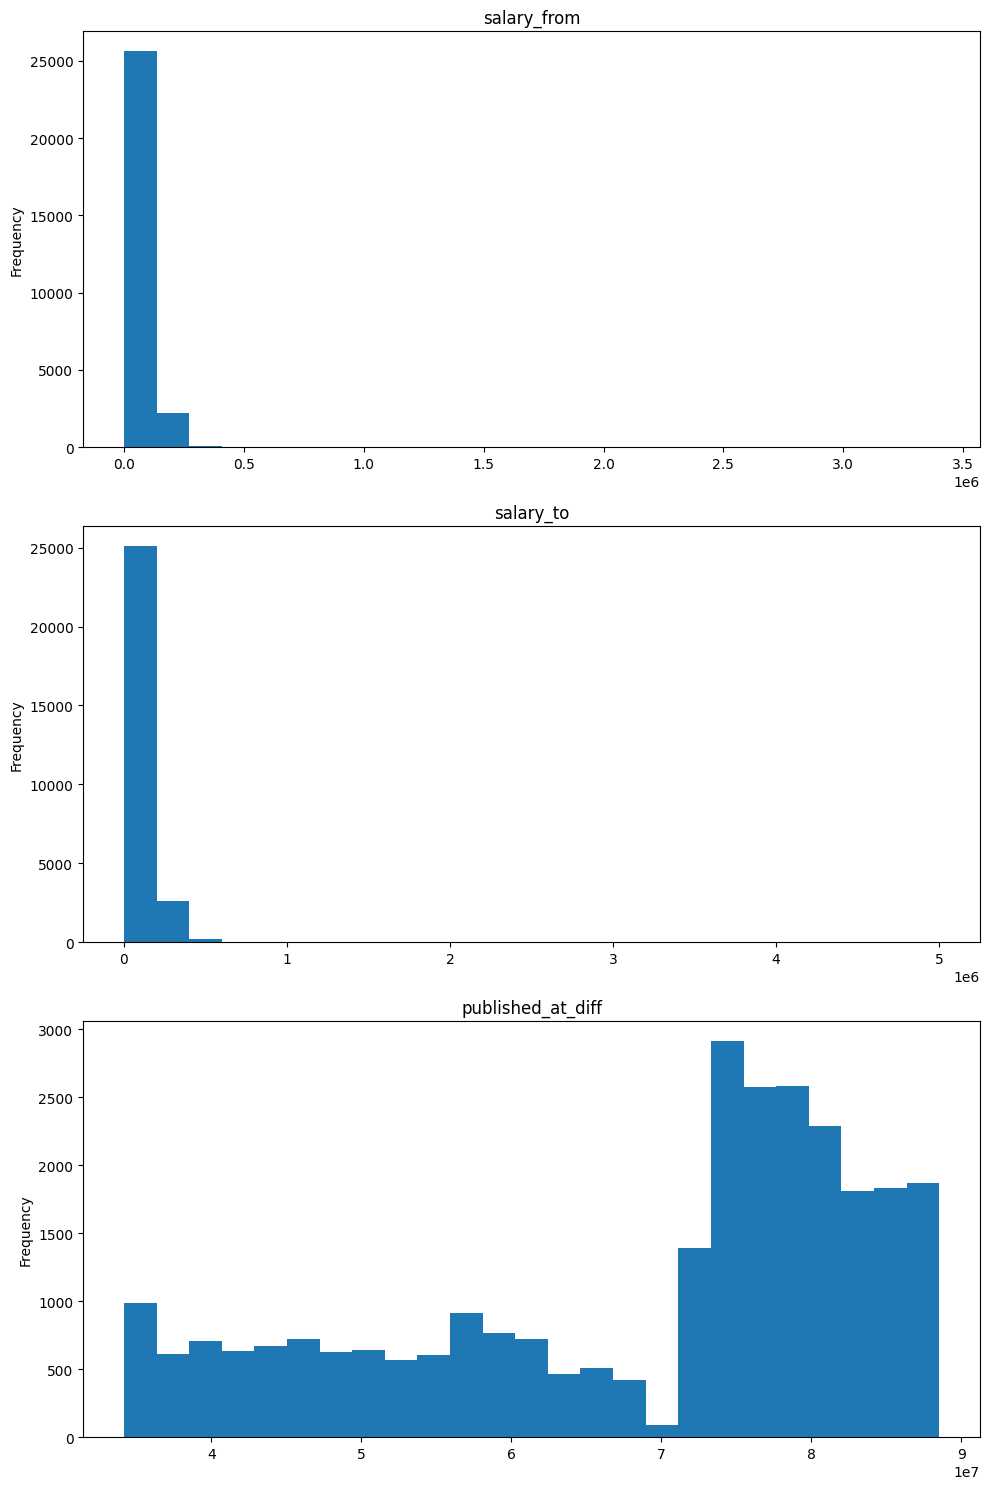

In [13]:
import matplotlib.pyplot as plt
df_numeric = df[['salary_from', 'salary_to', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric.columns):
    df_numeric[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

Нормализуем <i>publised_at_diff</i>:

In [14]:
df["published_at_diff"] = df["published_at_diff"] / 1e7

<H1>Категориальные / Category</H1>

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27786 non-null  object 
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 3.4+ MB


<H2>salary_gross</H2>

Для <i>salary_gross</i> нужно заполнить пропуски False и преобразовать из типа object в тип bool: 

In [16]:
df.salary_gross.fillna(False, inplace = True) 
df['salary_gross'] = df['salary_gross'].astype(bool)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_currency           27934 non-null  object 
 5   salary_gross              27934 non-null  bool   
 6   employer_name             27934 non-null  object 
 7   description               27933 non-null  object 
 8   area_id                   27934 non-null  int64  
 9   area_name                 27934 non-null  object 
 10  salary_to                 27934 non-null  float64
 11  published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 3.2+ MB


<H2>salary_currency</H2>

Посмотрим, сколько уникальных значений есть в <i>salary_currency</i>.

In [18]:
df['salary_currency'].value_counts()

salary_currency
RUR    27934
Name: count, dtype: int64

У всех строк одна и та же валюта, этот столбец можно удалить.

In [19]:
df = df.drop(columns=['salary_currency'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27933 non-null  object 
 7   area_id                   27934 non-null  int64  
 8   area_name                 27934 non-null  object 
 9   salary_to                 27934 non-null  float64
 10  published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 3.0+ MB


<H2>area_name и area_id</H2>

Разберемся с <i>area_id</i> и <i>area_name</i>.

In [21]:
map_id_to_name = {}
for idx in df.index:
    if df['area_id'][idx] in map_id_to_name:
        map_id_to_name[df['area_id'][idx]].add((df['area_name'][idx], ))
    else:
        map_id_to_name[df['area_id'][idx]] = set(((df['area_name'][idx], ), ))
map_id_to_name

{1: {('Москва',)},
 2: {('Санкт-Петербург',)},
 72: {('Пермь',)},
 4: {('Новосибирск',)},
 78: {('Самара',)},
 26: {('Воронеж',)},
 35: {('Иркутск',)},
 3: {('Екатеринбург',)},
 77: {('Рязань',)},
 24: {('Волгоград',)},
 76: {('Ростов-на-Дону',)},
 54: {('Красноярск',)},
 53: {('Краснодар',)},
 66: {('Нижний Новгород',)},
 96: {('Ижевск',)},
 247: {('Дзержинск (Нижегородская область)',)},
 41: {('Калининград',)},
 90: {('Томск',)},
 98: {('Ульяновск',)},
 130: {('Севастополь',)},
 68: {('Омск',)},
 43: {('Калуга',)},
 99: {('Уфа',)},
 22: {('Владивосток',)},
 49: {('Киров (Кировская область)',)},
 88: {('Казань',)},
 32: {('Иваново (Ивановская область)',)},
 1002: {('Минск',)},
 44: {('Петропавловск-Камчатский',)},
 112: {('Ярославль',)},
 160: {('Алматы',)},
 104: {('Челябинск',)},
 2734: {('Иннополис',)},
 92: {('Тула',)},
 71: {('Пенза',)},
 2088: {('Зеленоград',)},
 2059: {('Павловский Посад',)},
 159: {('Нур-Султан',)},
 83: {('Смоленск',)},
 79: {('Саратов',)},
 89: {('Тверь',)},

Удалим <i>area_id</i>, и посмотрим на то, сколько раз встречается тот или иной город.

In [22]:
df = df.drop(columns=['area_id'])

In [23]:
df['area_name'].value_counts()

area_name
Москва                         20512
Санкт-Петербург                 5393
Новосибирск                      201
Краснодар                        178
Екатеринбург                     158
                               ...  
Каменск-Шахтинский                 1
Стерлитамак                        1
Турция                             1
Донецк (Ростовская область)        1
Курган                             1
Name: count, Length: 156, dtype: int64

Начнем с area_name

Выделим несколько часто встречающихся городов, остальные заменим Other:

In [24]:
df.loc[df["area_name"].value_counts()[df["area_name"]].values < 150, "area_name"] = "Other"
df['area_name'].value_counts()

area_name
Москва             20512
Санкт-Петербург     5393
Other               1339
Новосибирск          201
Краснодар            178
Екатеринбург         158
Казань               153
Name: count, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27933 non-null  object 
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  float64
dtypes: bool(3), float64(3), object(4)
memory usage: 2.8+ MB


<H2>description</H2>

В колонке <i>description</i> есть много информации, написанной в виде HTML страницы. Есть вероятность, что там есть упоминание з/п в формате "<число> руб." или "<число> руб./час" или "<число> тыс. руб.". Попробуем их выцепить. Сначала удалим HTML теги из всех записей

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
def get_data(data):
    map_name_to_list = {}
    try:
        soup_ = BeautifulSoup(data, 'html.parser')
    except:
        return map_name_to_list
    if pd.isnull(data):
        return map_name_to_list
    prev_tag = None
    last_tag = None
    isFirst = True
    for tag in soup_.find_all('p'):
        if isFirst:
            prev_tag = tag
            isFirst = False
            pass
        tags = set(prev_tag.find_all_next('li')).intersection(set(tag.find_all_previous('li')))
        if len(tags) > 0:
            lst = []
            for cur_tag in tags:
                lst.append(cur_tag.get_text())
            map_name_to_list[prev_tag.get_text()] = lst
        last_tag = tag
        prev_tag = tag

    if last_tag == None:
        return map_name_to_list
    
    tags = set(last_tag.find_all_next('li'))
    if len(tags) > 0:
        lst = []
        for cur_tag in tags:
            lst.append(cur_tag.get_text())
        map_name_to_list[last_tag.get_text()] = lst

    return map_name_to_list
    
#mp = get_data(soup)

In [ ]:
df['description_parsed'] = df['description'].map(get_data)

In [ ]:
df['description_parsed'].head()

In [26]:
import re
df['description'] = pd.Series(df['description'],dtype=pd.StringDtype())
df.description = df.description.apply(lambda x: str(x).lower())

...

In [27]:
def manage_desc_exp(string):
    #print(string)
    pattern = r'опыт[а-яА-ЯёЁ ]+[0-9]+[-лгм ]+[а-яА-ЯеЁ ]+[;<]'
    year = 0
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        prev_ch = ' '
        for ch in match:
            if ch.isnumeric() and (first_numeric_found or prev_ch == ' '):
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                prev_ch = ch
                pass
            else:
                if first_numeric_found:
                    break
            prev_ch = ch
        try:
            cur_year = int(number)
        except ValueError:
            cur_year = 0
        if 'мес' in match:
            cur_year /= 12
        if cur_year > year and cur_year <= 10:
            year = cur_year
    return 1 if year == 0 else year

In [28]:
df['description_exp'] = df.description.map(manage_desc_exp)

In [29]:
df['description_exp'].value_counts()

description_exp
1.000000    26641
3.000000      582
2.000000      487
5.000000      105
0.500000       63
            ...  
9.000000        2
0.166667        1
0.333333        1
0.416667        1
0.666667        1
Name: count, Length: 15, dtype: int64

...

In [30]:
df.description = df.description.apply(lambda x: re.sub(r'<[^>]+>', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

Определим функцию, которая будет извлекать из строки description максимальную упомянотую зарплату. Если таковой нет, сделаем её равной 0. Также сделаем равной 0 зарплаты, которые получились меньше 1000. Такое могло произойти, если извлеченная зарплата была не той по смыслу, или была какая-то другая цена.

In [31]:
def manage_desc(string):
    #print(string)
    pattern = r'[0-9][0-9., ]+[0-9 ](тыс)?руб.?\/?[а-яА-Я ]*([0-9 ]+час)?(час)?(мес)?(день)?'
    max_salary = -1
    for match_raw in re.finditer(pattern, string):
        number = ''
        match = match_raw.group()
        #print(match)
        first_numeric_found = False
        for ch in match:
            if ch.isnumeric():
                number += ch
                first_numeric_found = True
            elif ch == ' ' or ch == ',' or ch == '.':
                pass
            else:
                if first_numeric_found:
                    break
        salary = int(number)
        if 'сут' in match or 'день' in match:
            salary *= 20
        elif 'час' in match:
            salary *= 160

        if 'тыс' in match or 'т.' in match:
            salary *= 1000
        
        if max_salary == -1 or salary > max_salary:
            max_salary = salary
    
    if (max_salary < 1000):
        return pd.NA
    else:
        return max_salary

#manage_desc(df['description'][23187])

Теперь преобразуем все description

In [32]:
df['description_salary'] = df.description.map(manage_desc)
df['description_salary'].value_counts()

description_salary
40000      333
50000      319
60000      287
30000      249
100000     232
          ... 
98000        1
5100000      1
15200        1
2170         1
25500        1
Name: count, Length: 340, dtype: int64

Заполним пустые значения значениями из <i>salary_from</i>

In [33]:
df['description_salary'].fillna(df['salary_from'], inplace = True) 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      27934 non-null  object 
 1   has_test                  27934 non-null  bool   
 2   response_letter_required  27934 non-null  bool   
 3   salary_from               27934 non-null  float64
 4   salary_gross              27934 non-null  bool   
 5   employer_name             27934 non-null  object 
 6   description               27934 non-null  object 
 7   area_name                 27934 non-null  object 
 8   salary_to                 27934 non-null  float64
 9   published_at_diff         27934 non-null  float64
 10  description_exp           27934 non-null  float64
 11  description_salary        27934 non-null  float64
dtypes: bool(3), float64(5), object(4)
memory usage: 3.2+ MB


In [35]:
df = df.drop(columns=['description'])

<H2>employer_name</H2>

Далее посмотрим на employer_name

In [36]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    927
Пятерочка                    669
Перекресток                  324
Билайн                       261
JCat.ru                       70
                            ... 
Торговая группа ПТК            1
LTG Consulting                 1
ExMail                         1
Албаков Руслан Борисович       1
Балтик Граунд Сервисес РУ      1
Name: count, Length: 13318, dtype: int64

Во первых, можно увидеть два разных написания "Пятерочка", возможно есть другие названия, которые отличаются в одном символе. Посмотрим на верхние 3 значения.

In [37]:
def near_equal(string, pattern):
    string1 = string.strip()
    string2 = pattern.strip()
    max_len = max(len(string1), len(string2))
    min_len = min(len(string1), len(string2))
    score = 0
    for i in range(0, min_len):
        if (string1[i] == string2[i]):
            score += 1

    return score / max_len

In [38]:
df['employer_name'] = df['employer_name'].apply(lambda x: x.lower())
df['employer_name'] = df['employer_name'].apply(lambda x: x.strip())

В списке <i>employer_name</i> есть ИП, написанные как ФИО. Заменим их всех на категорию "personname"

In [39]:
df['employer_name'] = df['employer_name'].apply(lambda x: "personname" if x.endswith('вич') or x.endswith('вна') or x.endswith('вич)') or x.endswith('вна)') else x) #or x.startswith('ип') or '(ип ' in x)
df['employer_name'].value_counts()

employer_name
personname                        1662
пятёрочка                          927
пятерочка                          669
перекресток                        324
билайн                             261
                                  ... 
шеф remont                           1
патронаж-сити                        1
агрегатор страхования блайсико       1
пластполимер-т                       1
балтик граунд сервисес ру            1
Name: count, Length: 12057, dtype: int64

In [40]:
import re

map_empl_name_to_count = {}
for idx in df.index:
    split = re.split('\W+', df['employer_name'][idx])
    split = list(filter(None, split))
    for entry in split:
        if len(entry) > 2:
            if entry in map_empl_name_to_count:
                map_empl_name_to_count[entry] = map_empl_name_to_count[entry] + 1
            else:
                for key in map_empl_name_to_count:
                    if near_equal(key, entry) >= 0.75:
                        map_empl_name_to_count[key] = map_empl_name_to_count[key] + 1
                        break;
                else:
                    map_empl_name_to_count[entry] = 1

In [ ]:
map_empl_name_to_count

In [41]:
map_empl_name_to_count1 = {k: v for k, v in map_empl_name_to_count.items() if v >= 300}
sorted_empl_names_to_count = sorted(map_empl_name_to_count1.items(), key=lambda x:x[1], reverse=True)

In [ ]:
sorted_empl_names_to_count

In [42]:
array_false = [False] * len(df)
array_true = [True] * len(df)

for key, val in sorted_empl_names_to_count:
    composite = 'employer_name_' + key
    df[composite] = array_false
df['employer_name_other'] = array_true

#df

In [43]:
for idx in df.index:
    split = re.split('\W+', df['employer_name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_empl_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'employer_name_' + key
                df[composite][idx] = True
                df['employer_name_other'][idx] = False

#df

In [44]:
df = df.drop(columns=['employer_name'])

<H2>name</H2>

Теперь рассмотрим последний столбец: <i>name</i>

In [45]:
df['name'].value_counts()

name
Менеджер по продажам                                   337
Менеджер по работе с клиентами                         201
Юрист                                                  162
Помощник юриста                                        149
Аналитик                                               145
                                                      ... 
Бизнес-аналитик(Внедренец/ Ведущий бизнес-аналитик)      1
Руководитель департамента коммерческой недвижимости      1
Логист- оператор / Грузчик (ТРК Европолис)               1
User Acquisition Manager                                 1
Копирайтер / контент менеджер                            1
Name: count, Length: 16395, dtype: int64

Сначала преобразуем всё к нижнему регистру:

In [46]:
df['name'] = df['name'].apply(lambda x: x.lower())
df['name'] = df['name'].apply(lambda x: x.strip())
df['name'].value_counts()

name
менеджер по продажам                                   340
менеджер по работе с клиентами                         202
юрист                                                  162
уборщица/уборщик                                       150
помощник юриста                                        149
                                                      ... 
руководитель департамента коммерческой недвижимости      1
логист- оператор / грузчик (трк европолис)               1
user acquisition manager                                 1
конструктор - технолог корпусной мебели                  1
копирайтер / контент менеджер                            1
Name: count, Length: 16089, dtype: int64

Можно увидеть перечисления через /, либо доп. указания в скобках. 

In [47]:
import re

map_name_to_count = {}
for idx in df.index:
    split = re.split('\W+', df['name'][idx])
    split = list(filter(None, split))
    for entry in split:
        if len(entry) > 2:
            if entry in map_name_to_count:
                map_name_to_count[entry] = map_name_to_count[entry] + 1
            else:
                for key in map_name_to_count:
                    if near_equal(key, entry) >= 0.75:
                        map_name_to_count[key] = map_name_to_count[key] + 1
                        break;
                else:
                    map_name_to_count[entry] = 1
#map_name_to_count

In [48]:
map_name_to_count1 = {k: v for k, v in map_name_to_count.items() if v >= 1100}
sorted_names_to_count = sorted(map_name_to_count1.items(), key=lambda x:x[1], reverse=True)
#sorted_names_to_count

In [49]:
array_false = [False] * len(df)
array_true = [True] * len(df)

for key, val in sorted_names_to_count:
    composite = 'name_' + key
    df[composite] = array_false
df['name_other'] = array_true

#df

In [50]:
for idx in df.index:
    split = re.split('\W+', df['name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'name_' + key
                df[composite][idx] = True
                df['name_other'][idx] = False

#df

In [51]:
df = df.drop(columns=['name'])

<H1>One-Hotting</H1>

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_test                   27934 non-null  bool   
 1   response_letter_required   27934 non-null  bool   
 2   salary_from                27934 non-null  float64
 3   salary_gross               27934 non-null  bool   
 4   area_name                  27934 non-null  object 
 5   salary_to                  27934 non-null  float64
 6   published_at_diff          27934 non-null  float64
 7   description_exp            27934 non-null  float64
 8   description_salary         27934 non-null  float64
 9   employer_name_personname   27934 non-null  bool   
 10  employer_name_пятёрочка    27934 non-null  bool   
 11  employer_name_группа       27934 non-null  bool   
 12  employer_name_компаний     27934 non-null  bool   
 13  employer_name_центр        27934 non-null  bool

Сделаем one-hotting категориальных фич:

In [53]:
df_one_hoted = df.copy()

#ONE_HOT_COL = ['published_at_diff']
ONE_HOT_COL = ['area_name'] #'name', 'employer_name', 'published_at_diff'

temp = pd.get_dummies(df_one_hoted[ONE_HOT_COL], prefix=ONE_HOT_COL, dtype=bool)

df_one_hoted = pd.concat([temp, df], axis=1)

df_one_hoted.head()

,area_name_Other,area_name_Екатеринбург,area_name_Казань,area_name_Краснодар,area_name_Москва,area_name_Новосибирск,area_name_Санкт-Петербург,has_test,response_letter_required,salary_from,...,name_developer,name_москва,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_other
id,,,,,,,,,,,,,,,,,,,,,
29083,False,False,False,False,True,False,False,False,False,40000.0,...,False,False,False,False,False,False,False,False,False,False
26052,False,False,False,False,True,False,False,False,False,120000.0,...,False,False,False,False,False,False,False,False,False,True
24055,False,False,False,False,True,False,False,False,False,40000.0,...,False,False,False,False,False,False,False,True,False,False
4408,False,False,False,False,True,False,False,False,False,33500.0,...,False,True,False,False,False,False,False,False,False,False
16856,False,False,False,False,True,False,False,False,True,30000.0,...,False,False,False,False,False,False,False,False,False,True


Удалим столбцы:

In [54]:
df_one_hoted = df_one_hoted.drop(columns=['area_name'])#, 'name', 'employer_name', 'published_at_diff' ])
#df_one_hoted = df_one_hoted.drop(columns=['published_at_diff'])

In [55]:
df_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_name_Other            27934 non-null  bool   
 1   area_name_Екатеринбург     27934 non-null  bool   
 2   area_name_Казань           27934 non-null  bool   
 3   area_name_Краснодар        27934 non-null  bool   
 4   area_name_Москва           27934 non-null  bool   
 5   area_name_Новосибирск      27934 non-null  bool   
 6   area_name_Санкт-Петербург  27934 non-null  bool   
 7   has_test                   27934 non-null  bool   
 8   response_letter_required   27934 non-null  bool   
 9   salary_from                27934 non-null  float64
 10  salary_gross               27934 non-null  bool   
 11  salary_to                  27934 non-null  float64
 12  published_at_diff          27934 non-null  float64
 13  description_exp            27934 non-null  floa

In [56]:
df = df_one_hoted

<H1>Корреляция</H1>

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

In [ ]:
#df = df.drop(columns=['description']) #, 'description'
#df['salary_from'] = np.log(df['salary_from'])
#df['description'] = np.exp(df['description'])

In [ ]:
#df['salary_from']

<H1>Создание модели</H1>

In [59]:
from sklearn.model_selection import train_test_split


#df_sampled = df.sample(20_000)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='salary_to'), df.salary_to, test_size=0.3, random_state=123458)

In [60]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
%%time
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

In [ ]:
model_SGR = SGDRegressor() # epsilon_insensitive, huber, squared_loss
model_SGR.fit(X_train, y_train)

y_pred_train = model_SGR.predict(X_train)
y_pred_test = model_SGR.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

In [ ]:
%%time
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def smape1(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

xg_model = XGBRegressor()
xg_model.fit(X_train, y_train)

y_pred_train = xg_model.predict(X_train)
y_pred_test = xg_model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

In [ ]:
xg_model.score(X_test, y_test)

In [ ]:
importances1 = dict(zip(xg_model.feature_names_in_, xg_model.feature_importances_))
importances1 = {k: v for k,v in sorted(importances1.items(), key=lambda x: x[1], reverse=True)}
importances1

In [62]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


model = RandomForestRegressor(n_estimators=100, max_depth=70, min_samples_split=3, random_state=123458)#, criterion='friedman_mse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

SMAPE train: 12.272030974498632, SMAPE test: 26.90032659347986
CPU times: user 14.6 s, sys: 0 ns, total: 14.6 s
Wall time: 15.1 s


In [ ]:
model.score(X_train, y_train)

In [63]:
model.score(X_test, y_test)

0.46326200569642384

In [ ]:
importances = dict(zip(model.feature_names_in_, model.feature_importances_))
importances = {k: v for k,v in sorted(importances.items(), key=lambda x: x[1], reverse=True)}

In [ ]:
importances

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 30, 50, None],
    'min_samples_split': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid, verbose=10)
						   
						
						
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

In [ ]:
model.score(X_test, y_test)

In [ ]:
%%time
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


#model = RandomForestRegressor(n_estimators=100)#criterion='friedman_mse')
#model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

In [64]:
%%time
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


cat_model = CatBoostRegressor(loss_function='Quantile', eval_metric='SMAPE', 
                              depth=6, iterations = 50000, random_state=123458,
                              learning_rate=0.01)
                              #bootstrap_type='MVS', mvs_reg=20, subsample=0.8,
                              #min_data_in_leaf=3, rsm=0.5)
cat_model.fit(X_train, 
              y_train,
              verbose=1000,
              eval_set=(X_test, y_test),
              use_best_model=True,  
)

y_pred_train = cat_model.predict(X_train)
y_pred_test = cat_model.predict(X_test)

#positive_predict = []
#for i in y_pred_test:
    #positive_predict.append(0 if i <0 else i)
    
#print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
#print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
#print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

0:	learn: 54.8282648	test: 54.8188497	best: 54.8188497 (0)	total: 67.5ms	remaining: 56m 15s
1000:	learn: 25.9059802	test: 25.8530798	best: 25.8530798 (1000)	total: 5.37s	remaining: 4m 22s
2000:	learn: 25.1492292	test: 25.3532940	best: 25.3532940 (2000)	total: 11.9s	remaining: 4m 44s
3000:	learn: 24.3879038	test: 24.8946554	best: 24.8946554 (3000)	total: 17.6s	remaining: 4m 35s
4000:	learn: 23.8041260	test: 24.6039654	best: 24.6039654 (4000)	total: 23.5s	remaining: 4m 29s
5000:	learn: 23.3406025	test: 24.4131166	best: 24.4128389 (4997)	total: 29.5s	remaining: 4m 25s
6000:	learn: 22.9896951	test: 24.3318168	best: 24.3318085 (5999)	total: 35.2s	remaining: 4m 17s
7000:	learn: 22.6909258	test: 24.2599707	best: 24.2414368 (6967)	total: 42.1s	remaining: 4m 18s
8000:	learn: 22.4771771	test: 24.2101102	best: 24.1936127 (7917)	total: 49.1s	remaining: 4m 17s
9000:	learn: 22.2824847	test: 24.1706649	best: 24.1494109 (8921)	total: 57.8s	remaining: 4m 23s
10000:	learn: 22.1140879	test: 24.1453611	be

In [65]:
cat_model.score(X_test, y_test)

0.4964476601103416

In [66]:
importances1 = dict(zip(cat_model.feature_names_, cat_model.feature_importances_))
importances1 = {k: v for k,v in sorted(importances1.items(), key=lambda x: x[1], reverse=True)}

In [67]:
importances1

{'salary_from': 36.94235861759683,
 'description_salary': 21.7399573302938,
 'published_at_diff': 19.030366590039712,
 'name_developer': 2.433671398644465,
 'name_продажам': 2.3788189943908726,
 'salary_gross': 2.0303990588041887,
 'employer_name_other': 1.8310385776404021,
 'name_разработчик': 1.7857609128180663,
 'employer_name_personname': 1.3325351794735618,
 'area_name_Москва': 1.0393796579136905,
 'name_продавец': 0.9405054262035186,
 'name_other': 0.911904394678071,
 'name_менеджер': 0.8757002953735857,
 'area_name_Санкт-Петербург': 0.7487668905973249,
 'name_специалист': 0.7060663111026925,
 'description_exp': 0.5997471501629382,
 'employer_name_компаний': 0.5964659725820974,
 'has_test': 0.516634968993666,
 'response_letter_required': 0.48452971732003874,
 'name_программист': 0.464518825732268,
 'name_работе': 0.3238745333540395,
 'employer_name_центр': 0.30733010855756177,
 'employer_name_группа': 0.30666796712249905,
 'name_удаленная': 0.2822425501315229,
 'name_аналитик': 0

<H1>Тестовая дата</H1>

Загрузим тестовую таблицу:

In [68]:
df_test = pd.read_csv('X_test.csv', parse_dates=['published_at', 'created_at'])

Сразу уберем столбцы salary_currency (одно и то же значение), created_at (совпадает с published_at) и area_id (аналогично area_name):

In [69]:
df_test = df_test.drop(columns=['salary_currency', 'created_at', 'area_id'])#, 'has_test', 'response_letter_required', 'salary_gross'])

In [70]:
df_test = df_test.set_index('id')

Заполняем salary_gross, если есть пропуски:

In [71]:
df_test.salary_gross.fillna(False, inplace = True) 
df_test['salary_gross'] = df_test['salary_gross'].astype(bool)

Заполняем пустые salary_from частым значением:

In [72]:
df_test.salary_from.fillna(df_test.salary_from.mode()[0], inplace = True)

Преобразуем published_at, как и с обучаемым dataset:

In [73]:
df_test['published_at_diff'] = df_test['published_at'].map(lambda x: datetime.timestamp(datetime(2023, 1, 1)) - x.timestamp())

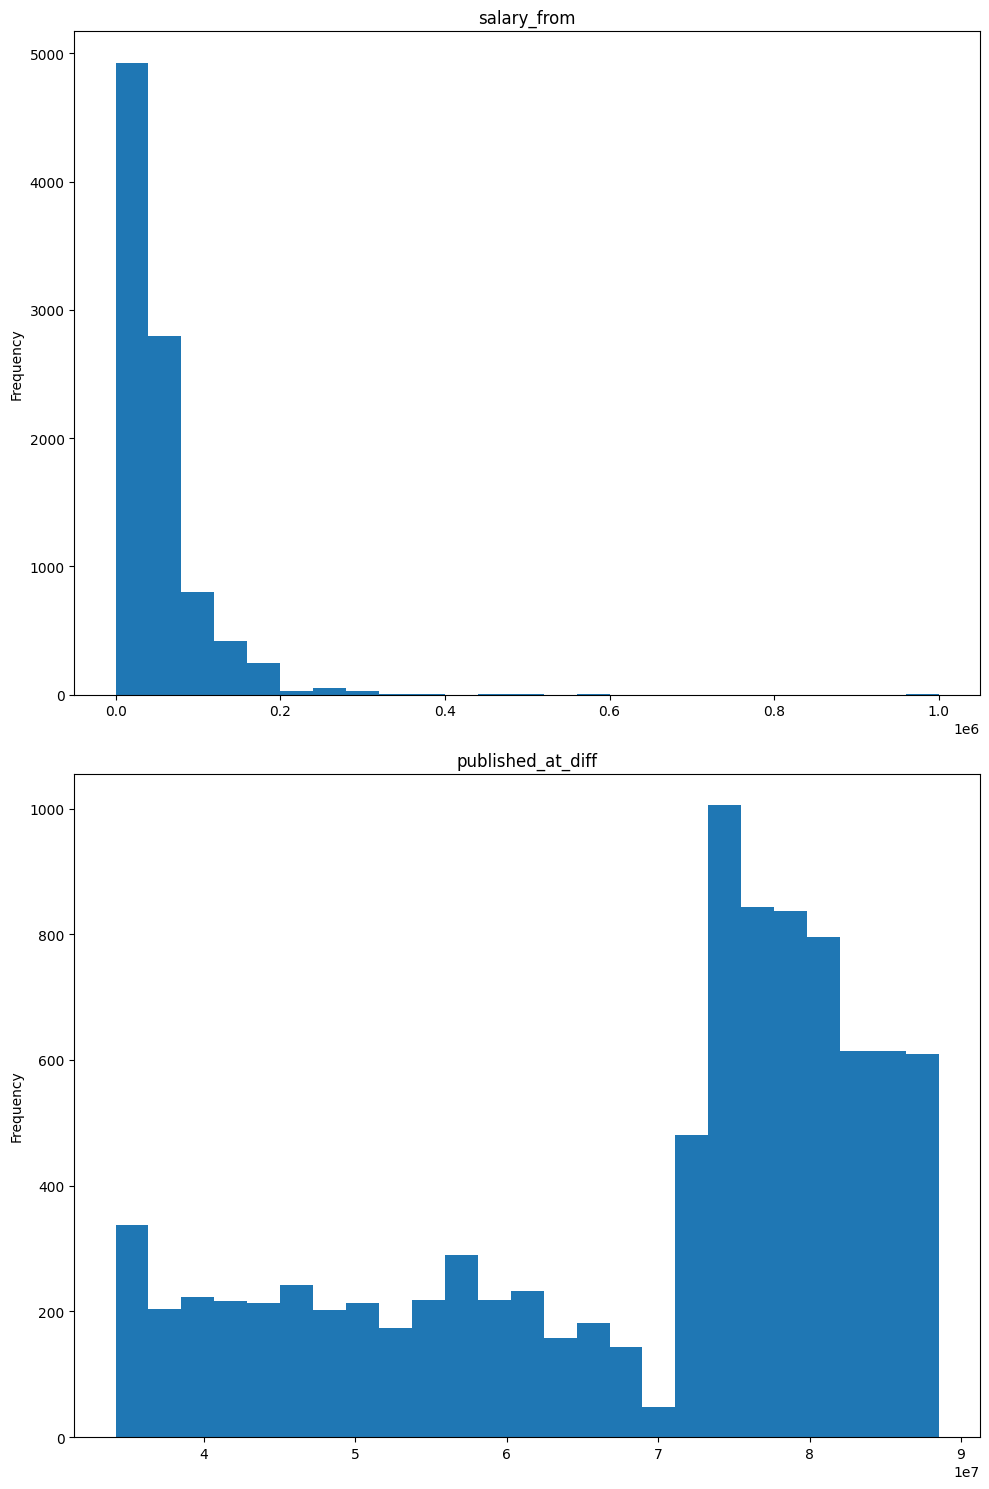

In [74]:
import matplotlib.pyplot as plt
df_numeric1 = df_test[['salary_from', 'published_at_diff']]
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric1.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric1.columns):
    df_numeric1[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [75]:
df_test["published_at_diff"] = df_test["published_at_diff"] / 1e7
#df_test['published_at_diff'] = df_test['published_at_diff'].map(lambda x: "Recent" if x < 5 else "Middle" if x >= 5 and x < 7 else "Old")
df_test = df_test.drop(columns=['published_at'])

Преобразуем description:

In [76]:
df_test['description'] = pd.Series(df_test['description'],dtype=pd.StringDtype())
df_test.description = df_test.description.apply(lambda x: str(x).lower())

In [77]:
df_test['description_exp'] = df_test.description.map(manage_desc_exp)
df_test['description_exp'].value_counts()

description_exp
1.000000     8854
3.000000      215
2.000000      162
5.000000       37
0.500000       21
4.000000        5
6.000000        5
10.000000       5
0.250000        4
0.083333        2
0.333333        1
8.000000        1
Name: count, dtype: int64

In [78]:
df_test.description = df_test.description.apply(lambda x: re.sub(r'<[^>]+>', ' ', str(x))) #</?[A-Za-z0-9]+ ?/?>

In [79]:
df_test['description_salary'] = df_test.description.map(manage_desc)
df_test['description_salary'].value_counts()

description_salary
40000          118
60000           98
50000           84
30000           79
100000          73
              ... 
19500000         1
1375             1
92400            1
30000600000      1
238000           1
Name: count, Length: 208, dtype: int64

In [80]:
df_test['description_salary'].fillna(df_test.salary_from, inplace = True) 

In [81]:
df_test = df_test.drop(columns=['description'])

Для area_name, оставим название, если в обучаемом dataset есть столбец, иначе заменяем на Other:

In [82]:
df_test['area_name'] = df_test['area_name'].map(lambda x: x if ('area_name_' + x) in df.columns else "Other")

In [83]:
df_test['area_name'].value_counts()

area_name
Москва             6754
Санкт-Петербург    1877
Other               454
Новосибирск          71
Казань               54
Краснодар            52
Екатеринбург         50
Name: count, dtype: int64

Преобразуем employer_name к нижнему регистру, и сделаем те же преобразования, что и в обучаемом dataset:

In [84]:
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: x.lower())
df_test['employer_name'] = df_test['employer_name'].apply(lambda x: x.strip())

In [85]:
array_false1 = [False] * len(df_test)
array_true1 = [True] * len(df_test)

for key, val in sorted_empl_names_to_count:
    composite = 'employer_name_' + key
    df_test[composite] = array_false1
df_test['employer_name_other'] = array_true1

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,area_name,published_at_diff,description_exp,description_salary,employer_name_personname,employer_name_пятёрочка,employer_name_группа,employer_name_компаний,employer_name_центр,employer_name_group,employer_name_сеть,employer_name_перекресток,employer_name_other
id,,,,,,,,,,,,,,,,,,,
20978,Техник по инструменту / Специалист по инструменту (Ауди Центр Таганка),False,False,35000.0,False,автоспеццентр,Москва,8.757062,1.0,35000.0,False,False,False,False,False,False,False,False,True
3102,Диспетчер по заказам,False,False,20000.0,False,автовыкуп,Москва,7.478465,1.0,20000.0,False,False,False,False,False,False,False,False,True
14731,Frontend Developer в Focus Calendar,False,False,200000.0,False,focus calendar,Москва,4.403157,1.0,200000.0,False,False,False,False,False,False,False,False,True
16113,Системный аналитик,False,False,150000.0,False,intech,Москва,4.412885,1.0,150000.0,False,False,False,False,False,False,False,False,True
8410,Front-end разработчик (JavaScript),False,False,80000.0,False,кравцов и.н.,Other,6.209183,1.0,80000.0,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,Обходчик объекта,False,False,40000.0,False,монтажспецстрой,Москва,8.074513,1.0,40000.0,False,False,False,False,False,False,False,False,True
34298,IT рекрутер (удаленно),False,False,40000.0,False,soft personal,Новосибирск,6.692967,1.0,40000.0,False,False,False,False,False,False,False,False,True
33921,"Старший продавец-кассир (Москва, бульвар Яна Райниса, 26к1)",False,False,35000.0,True,пятёрочка,Москва,7.767509,1.0,35000.0,False,False,False,False,False,False,False,False,True


In [86]:
for idx in df_test.index:
    split = re.split('\W+', df_test['employer_name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_empl_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'employer_name_' + key
                df_test[composite][idx] = True
                df_test['employer_name_other'][idx] = False

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,employer_name,area_name,published_at_diff,description_exp,description_salary,employer_name_personname,employer_name_пятёрочка,employer_name_группа,employer_name_компаний,employer_name_центр,employer_name_group,employer_name_сеть,employer_name_перекресток,employer_name_other
id,,,,,,,,,,,,,,,,,,,
20978,Техник по инструменту / Специалист по инструменту (Ауди Центр Таганка),False,False,35000.0,False,автоспеццентр,Москва,8.757062,1.0,35000.0,False,False,False,False,False,False,False,False,True
3102,Диспетчер по заказам,False,False,20000.0,False,автовыкуп,Москва,7.478465,1.0,20000.0,False,False,False,False,False,False,False,False,True
14731,Frontend Developer в Focus Calendar,False,False,200000.0,False,focus calendar,Москва,4.403157,1.0,200000.0,False,False,False,False,False,False,False,False,True
16113,Системный аналитик,False,False,150000.0,False,intech,Москва,4.412885,1.0,150000.0,False,False,False,False,False,False,False,False,True
8410,Front-end разработчик (JavaScript),False,False,80000.0,False,кравцов и.н.,Other,6.209183,1.0,80000.0,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,Обходчик объекта,False,False,40000.0,False,монтажспецстрой,Москва,8.074513,1.0,40000.0,False,False,False,False,False,False,False,False,True
34298,IT рекрутер (удаленно),False,False,40000.0,False,soft personal,Новосибирск,6.692967,1.0,40000.0,False,False,False,False,False,False,False,False,True
33921,"Старший продавец-кассир (Москва, бульвар Яна Райниса, 26к1)",False,False,35000.0,True,пятёрочка,Москва,7.767509,1.0,35000.0,False,True,False,False,False,False,False,False,False


In [87]:
df_test = df_test.drop(columns=['employer_name'])

Ту же процедуру проделываем с name:

In [88]:
df_test['name'] = df_test['name'].apply(lambda x: x.lower())
df_test['name'] = df_test['name'].apply(lambda x: x.strip())

In [89]:
array_false1 = [False] * len(df_test)
array_true1 = [True] * len(df_test)

for key, val in sorted_names_to_count:
    composite = 'name_' + key
    df_test[composite] = array_false1
df_test['name_other'] = array_true1

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,area_name,published_at_diff,description_exp,description_salary,employer_name_personname,...,name_developer,name_москва,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_other
id,,,,,,,,,,,,,,,,,,,,,
20978,техник по инструменту / специалист по инструменту (ауди центр таганка),False,False,35000.0,False,Москва,8.757062,1.0,35000.0,False,...,False,False,False,False,False,False,False,False,False,True
3102,диспетчер по заказам,False,False,20000.0,False,Москва,7.478465,1.0,20000.0,False,...,False,False,False,False,False,False,False,False,False,True
14731,frontend developer в focus calendar,False,False,200000.0,False,Москва,4.403157,1.0,200000.0,False,...,False,False,False,False,False,False,False,False,False,True
16113,системный аналитик,False,False,150000.0,False,Москва,4.412885,1.0,150000.0,False,...,False,False,False,False,False,False,False,False,False,True
8410,front-end разработчик (javascript),False,False,80000.0,False,Other,6.209183,1.0,80000.0,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,обходчик объекта,False,False,40000.0,False,Москва,8.074513,1.0,40000.0,False,...,False,False,False,False,False,False,False,False,False,True
34298,it рекрутер (удаленно),False,False,40000.0,False,Новосибирск,6.692967,1.0,40000.0,False,...,False,False,False,False,False,False,False,False,False,True
33921,"старший продавец-кассир (москва, бульвар яна райниса, 26к1)",False,False,35000.0,True,Москва,7.767509,1.0,35000.0,False,...,False,False,False,False,False,False,False,False,False,True


In [90]:
for idx in df_test.index:
    split = re.split('\W+', df_test['name'][idx])
    split = list(filter(None, split))
    for entry in split:
        for key, val in sorted_names_to_count:
            if near_equal(entry, key) >= 0.75:
                composite = 'name_' + key
                df_test[composite][idx] = True
                df_test['name_other'][idx] = False

df_test

,name,has_test,response_letter_required,salary_from,salary_gross,area_name,published_at_diff,description_exp,description_salary,employer_name_personname,...,name_developer,name_москва,name_специалист,name_инженер,name_удаленная,name_работе,name_уборщик,name_программист,name_аналитик,name_other
id,,,,,,,,,,,,,,,,,,,,,
20978,техник по инструменту / специалист по инструменту (ауди центр таганка),False,False,35000.0,False,Москва,8.757062,1.0,35000.0,False,...,False,False,True,False,False,False,False,False,False,False
3102,диспетчер по заказам,False,False,20000.0,False,Москва,7.478465,1.0,20000.0,False,...,False,False,False,False,False,False,False,False,False,True
14731,frontend developer в focus calendar,False,False,200000.0,False,Москва,4.403157,1.0,200000.0,False,...,True,False,False,False,False,False,False,False,False,False
16113,системный аналитик,False,False,150000.0,False,Москва,4.412885,1.0,150000.0,False,...,False,False,False,False,False,False,False,False,True,False
8410,front-end разработчик (javascript),False,False,80000.0,False,Other,6.209183,1.0,80000.0,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29490,обходчик объекта,False,False,40000.0,False,Москва,8.074513,1.0,40000.0,False,...,False,False,False,False,False,False,False,False,False,True
34298,it рекрутер (удаленно),False,False,40000.0,False,Новосибирск,6.692967,1.0,40000.0,False,...,False,False,False,False,True,False,False,False,False,False
33921,"старший продавец-кассир (москва, бульвар яна райниса, 26к1)",False,False,35000.0,True,Москва,7.767509,1.0,35000.0,False,...,False,True,False,False,False,False,False,False,False,False


In [91]:
df_test = df_test.drop(columns=['name'])

Делаем one-hotting категориальных фич:

In [92]:
df_one_hoted_test = df_test.copy()

ONE_HOT_COL_TEST = ['area_name']#,  'published_at_diff'] #'employer_name',

temp_test = pd.get_dummies(df_one_hoted_test[ONE_HOT_COL_TEST], prefix=ONE_HOT_COL_TEST, dtype=bool)

df_one_hoted_test = pd.concat([temp_test, df_test], axis=1)

In [93]:
df_one_hoted_test = df_one_hoted_test.drop(columns=['area_name'])#, 'published_at_diff']) #'employer_name', 

In [94]:
df_test = df_one_hoted_test

Проверим, что все столбцы, которые есть в обучаемом dataset, есть и в тестовом dataset:

In [95]:
for columnName in df_test.columns:
    print(columnName)

area_name_Other
area_name_Екатеринбург
area_name_Казань
area_name_Краснодар
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
has_test
response_letter_required
salary_from
salary_gross
published_at_diff
description_exp
description_salary
employer_name_personname
employer_name_пятёрочка
employer_name_группа
employer_name_компаний
employer_name_центр
employer_name_group
employer_name_сеть
employer_name_перекресток
employer_name_other
name_менеджер
name_разработчик
name_продавец
name_продажам
name_кассир
name_developer
name_москва
name_специалист
name_инженер
name_удаленная
name_работе
name_уборщик
name_программист
name_аналитик
name_other


In [96]:
for columnName in df.columns:
    print(columnName)
    if not (columnName in df_test.columns) and (columnName != 'salary_to'):
        df_test[columnName] = [False] * df_test.shape[0]

area_name_Other
area_name_Екатеринбург
area_name_Казань
area_name_Краснодар
area_name_Москва
area_name_Новосибирск
area_name_Санкт-Петербург
has_test
response_letter_required
salary_from
salary_gross
salary_to
published_at_diff
description_exp
description_salary
employer_name_personname
employer_name_пятёрочка
employer_name_группа
employer_name_компаний
employer_name_центр
employer_name_group
employer_name_сеть
employer_name_перекресток
employer_name_other
name_менеджер
name_разработчик
name_продавец
name_продажам
name_кассир
name_developer
name_москва
name_специалист
name_инженер
name_удаленная
name_работе
name_уборщик
name_программист
name_аналитик
name_other


In [97]:
df_test.columns

Index(['area_name_Other', 'area_name_Екатеринбург', 'area_name_Казань',
       'area_name_Краснодар', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'has_test', 'response_letter_required',
       'salary_from', 'salary_gross', 'published_at_diff', 'description_exp',
       'description_salary', 'employer_name_personname',
       'employer_name_пятёрочка', 'employer_name_группа',
       'employer_name_компаний', 'employer_name_центр', 'employer_name_group',
       'employer_name_сеть', 'employer_name_перекресток',
       'employer_name_other', 'name_менеджер', 'name_разработчик',
       'name_продавец', 'name_продажам', 'name_кассир', 'name_developer',
       'name_москва', 'name_специалист', 'name_инженер', 'name_удаленная',
       'name_работе', 'name_уборщик', 'name_программист', 'name_аналитик',
       'name_other'],
      dtype='object')

In [98]:
df.columns

Index(['area_name_Other', 'area_name_Екатеринбург', 'area_name_Казань',
       'area_name_Краснодар', 'area_name_Москва', 'area_name_Новосибирск',
       'area_name_Санкт-Петербург', 'has_test', 'response_letter_required',
       'salary_from', 'salary_gross', 'salary_to', 'published_at_diff',
       'description_exp', 'description_salary', 'employer_name_personname',
       'employer_name_пятёрочка', 'employer_name_группа',
       'employer_name_компаний', 'employer_name_центр', 'employer_name_group',
       'employer_name_сеть', 'employer_name_перекресток',
       'employer_name_other', 'name_менеджер', 'name_разработчик',
       'name_продавец', 'name_продажам', 'name_кассир', 'name_developer',
       'name_москва', 'name_специалист', 'name_инженер', 'name_удаленная',
       'name_работе', 'name_уборщик', 'name_программист', 'name_аналитик',
       'name_other'],
      dtype='object')

Переупорядочиваем столбцы, чтобы соответствовать обучаемой выборке:

In [99]:
columns = df.columns.tolist();
columns.remove('salary_to');
df_test = df_test[columns]

Делаем предсказания:

In [100]:
y_pred_test1 = cat_model.predict(df_test)

Пишем требуемый результат в файл:

In [101]:
df_test_full = df_test.assign(salary_to = y_pred_test1)

In [102]:
df_output = pd.concat([df_test_full['salary_to']])
df_output

id
20978     41461.277444
3102      32731.847459
14731    297056.066125
16113    210727.662089
8410     121724.454491
             ...      
29490     57507.475233
34298     56634.725610
33921     38997.594319
8886      74613.679364
23978     42371.441440
Name: salary_to, Length: 9312, dtype: float64

In [103]:
from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_output.to_csv(filepath)  